# An Introduction to SageMaker Random Cut Forests 
[Link](https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/random_cut_forest/random_cut_forest.html)

[random_cut_forest.ipynb](https://github.com/aws/amazon-sagemaker-examples/blob/main/introduction_to_amazon_algorithms/random_cut_forest/random_cut_forest.ipynb)

In [1]:
import boto3
import botocore
import sagemaker
import sys


bucket = (
    sagemaker.Session().default_bucket()
)  # Feel free to change to another bucket you have access to
prefix = "sagemaker/rcf-benchmarks"
execution_role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# S3 bucket where the original data is downloaded and stored.
downloaded_data_bucket = f"sagemaker-sample-files"
downloaded_data_prefix = "datasets/tabular/anomaly_benchmark_taxi"


def check_bucket_permission(bucket):
    # check if the bucket exists
    permission = False
    try:
        boto3.Session().client("s3").head_bucket(Bucket=bucket)
    except botocore.exceptions.ParamValidationError as e:
        print(
            "Hey! You either forgot to specify your S3 bucket"
            " or you gave your bucket an invalid name!"
        )
    except botocore.exceptions.ClientError as e:
        if e.response["Error"]["Code"] == "403":
            print(f"Hey! You don't have permission to access the bucket, {bucket}.")
        elif e.response["Error"]["Code"] == "404":
            print(f"Hey! Your bucket, {bucket}, doesn't exist!")
        else:
            raise
    else:
        permission = True
    return permission


if check_bucket_permission(bucket):
    print(f"Training input/output will be stored in: s3://{bucket}/{prefix}")
if check_bucket_permission(downloaded_data_bucket):
    print(
        f"Downloaded training data will be read from s3://{downloaded_data_bucket}/{downloaded_data_prefix}"
    )

Training input/output will be stored in: s3://sagemaker-ap-northeast-2-677146750822/sagemaker/rcf-benchmarks
Downloaded training data will be read from s3://sagemaker-sample-files/datasets/tabular/anomaly_benchmark_taxi


In [2]:
%%time

import pandas as pd

data_filename = "NAB_nyc_taxi.csv"
s3 = boto3.client("s3")
s3.download_file(downloaded_data_bucket, f"{downloaded_data_prefix}/{data_filename}", data_filename)
taxi_data = pd.read_csv(data_filename, delimiter=",")

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


CPU times: user 81.6 ms, sys: 10.1 ms, total: 91.8 ms
Wall time: 1.63 s


In [3]:
taxi_data.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


Matplotlib is building the font cache; this may take a moment.


<AxesSubplot:>

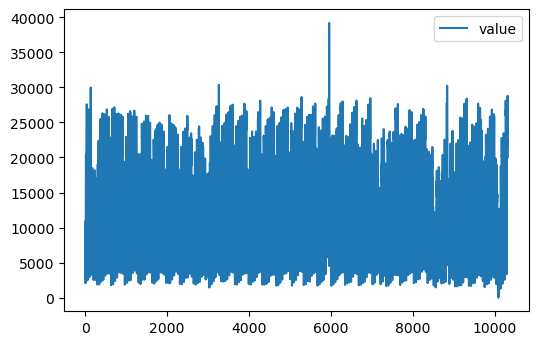

In [4]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.dpi"] = 100

taxi_data.plot()

<AxesSubplot:>

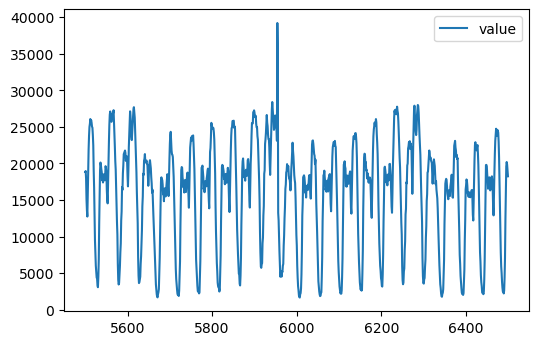

In [5]:
taxi_data[5500:6500].plot()

In [6]:
taxi_data[5952:6000]

,timestamp,value
5952,2014-11-02 00:00:00,25110
5953,2014-11-02 00:30:00,23109
5954,2014-11-02 01:00:00,39197
5955,2014-11-02 01:30:00,35212
5956,2014-11-02 02:00:00,13259
5957,2014-11-02 02:30:00,12250
5958,2014-11-02 03:00:00,10013
5959,2014-11-02 03:30:00,7898
5960,2014-11-02 04:00:00,6375
5961,2014-11-02 04:30:00,4532


In [7]:
from sagemaker import RandomCutForest

session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(
    role=execution_role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    data_location=f"s3://{bucket}/{prefix}/",
    output_path=f"s3://{bucket}/{prefix}/output",
    num_samples_per_tree=512,
    num_trees=50,
)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(taxi_data.value.to_numpy().reshape(-1, 1)))

2023-04-03 08:54:21 Starting - Starting the training job...
2023-04-03 08:54:49 Starting - Preparing the instances for trainingProfilerReport-1680512061: InProgress
......
2023-04-03 08:55:47 Downloading - Downloading input data...
2023-04-03 08:56:07 Training - Downloading the training image.........
2023-04-03 08:57:48 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/03/2023 08:57:50 INFO 140720089134912] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'num_samples_per_tree': 256, 'num_trees': 100, 'force_dense': 'true', 'eval_metrics': ['accuracy', 'precision_recall_fscore'], 'epochs': 1, 'mini_batch_size': 1000, '_log_level': 'info', '_kvstore': 'dist_async', '_num_kv_servers': 'auto', '_num_gpus': 'auto', '_tuning_objective_metric': '', '_ftp_port': 8999}
[04/03/2023 08:57:50 INFO 140720089134912]

In [8]:
print(f"Training job name: {rcf.latest_training_job.job_name}")

Training job name: randomcutforest-2023-04-03-08-54-21-760


In [9]:
rcf_inference = rcf.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

--------!

In [10]:
print(f"Endpoint name: {rcf_inference.endpoint}")

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Endpoint name: randomcutforest-2023-04-03-08-58-34-484


In [11]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

rcf_inference.serializer = CSVSerializer()
rcf_inference.deserializer = JSONDeserializer()

In [12]:
taxi_data_numpy = taxi_data.value.to_numpy().reshape(-1, 1)
print(taxi_data_numpy[:6])
results = rcf_inference.predict(
    taxi_data_numpy[:6], initial_args={"ContentType": "text/csv", "Accept": "application/json"}
)

[[10844]
 [ 8127]
 [ 6210]
 [ 4656]
 [ 3820]
 [ 2873]]


In [13]:
results = rcf_inference.predict(taxi_data_numpy)
scores = [datum["score"] for datum in results["scores"]]

# add scores to taxi data frame and print first few values
taxi_data["score"] = pd.Series(scores, index=taxi_data.index)
taxi_data.head()

,timestamp,value,score
0,2014-07-01 00:00:00,10844,0.913760
1,2014-07-01 00:30:00,8127,1.000391
2,2014-07-01 01:00:00,6210,0.962815
3,2014-07-01 01:30:00,4656,0.872729
4,2014-07-01 02:00:00,3820,0.928844


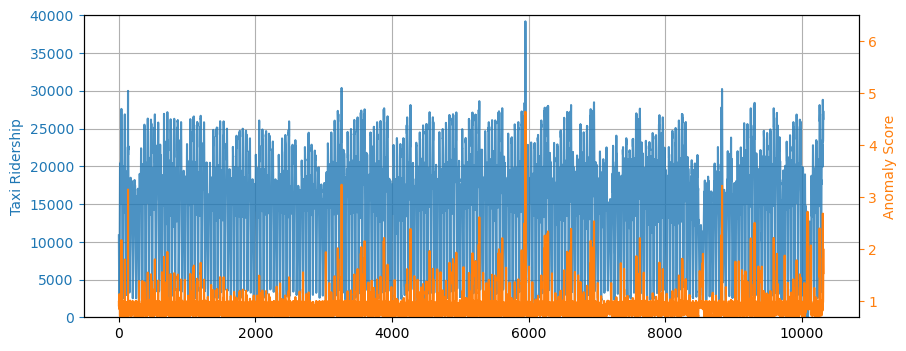

In [14]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the
# anomaly found earlier in this notebook
#
start, end = 0, len(taxi_data)
# start, end = 5500, 6500
taxi_data_subset = taxi_data[start:end]

ax1.plot(taxi_data_subset["value"], color="C0", alpha=0.8)
ax2.plot(taxi_data_subset["score"], color="C1")

ax1.grid(which="major", axis="both")

ax1.set_ylabel("Taxi Ridership", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")

ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")

ax1.set_ylim(0, 40000)
ax2.set_ylim(min(scores), 1.4 * max(scores))
fig.set_figwidth(10)

In [15]:
score_mean = taxi_data["score"].mean()
score_std = taxi_data["score"].std()
score_cutoff = score_mean + 3 * score_std

anomalies = taxi_data_subset[taxi_data_subset["score"] > score_cutoff]
anomalies

,timestamp,value,score
37,2014-07-01 18:30:00,27598,2.170770
38,2014-07-01 19:00:00,26827,1.763742
87,2014-07-02 19:30:00,26872,1.797432
134,2014-07-03 19:00:00,29985,3.143511
527,2014-07-11 23:30:00,26873,1.800181
...,...,...,...
10309,2015-01-31 18:30:00,27286,1.992962
10310,2015-01-31 19:00:00,28804,2.680437
10311,2015-01-31 19:30:00,27773,2.253552
10317,2015-01-31 22:30:00,27309,2.000903


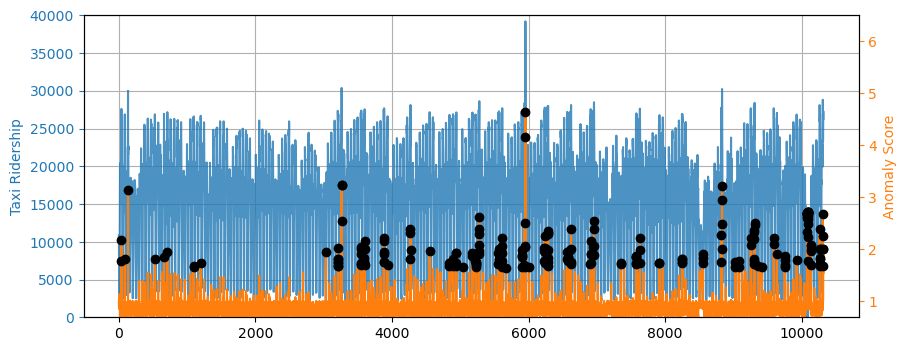

In [16]:
ax2.plot(anomalies.index, anomalies.score, "ko")
fig

In [18]:
score_cutoff

1.62274352130424

In [17]:
# sagemaker.Session().delete_endpoint(rcf_inference.endpoint)